<a href="https://colab.research.google.com/github/DrSunday1405/Fault-Diagnosis-Using-Hybrid-Transfer-Learning-for-VNF-based-5G-Core-Networks/blob/main/MLP_based_feature_selection_%2B_tradaboost_%EF%BC%88hybrid_TL_%E7%9A%84%E6%9C%80%E7%BB%88%E7%89%88%E6%9C%AC%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, mutual_info_classif

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [ ]:
print(torch.__version__)

2.3.0+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_raw_tab_A = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/train_A_select_by_tradaboost.csv')
data_raw_tab_C_train = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/train_data_C.csv')
data_raw_tab_C_test = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/test_data_C.csv')
data_raw_tab_A.head()

,Unnamed: 0,time,source_name,y_true(fc),amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,11,20210128183808-26_20210128183850,network-5gc-a,amfx1_ens5_interface-loss-start-70,0,0,0,1,1,1,...,0,0,-208,0,-0.150,0.10,0,0.0,-1.390000e-17,0.200
1,20,20210128191631-44_20210128191720,network-5gc-a,normal,0,0,0,1,1,1,...,0,0,648,0,-0.010,0.05,0,0.0,-1.350000e-01,0.095
2,23,20210128192917-50_20210128193000,network-5gc-a,ausfx1_ens4_interface-down,0,0,0,1,1,1,...,4,0,-90060,-4,-0.565,0.03,0,0.0,6.500000e-02,0.490
3,34,20210128201626-72_20210128201710,network-5gc-a,amfx1_bridge-delif,0,0,0,1,1,1,...,-4,0,89540,4,0.375,0.07,0,0.0,-1.150000e-01,-0.295
4,37,20210128202923-78_20210128203010,network-5gc-a,amfx1_memory-stress-start,0,0,0,1,1,1,...,-1,0,13384,1,-0.160,0.03,0,0.0,5.000000e-03,0.135


In [ ]:
del data_raw_tab_A['Unnamed: 0']  # 删除未命名列，不过这个列是哪来的不清楚
data_raw_tab_A.head()

,time,source_name,y_true(fc),amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128183808-26_20210128183850,network-5gc-a,amfx1_ens5_interface-loss-start-70,0,0,0,1,1,1,1,...,0,0,-208,0,-0.150,0.10,0,0.0,-1.390000e-17,0.200
1,20210128191631-44_20210128191720,network-5gc-a,normal,0,0,0,1,1,1,1,...,0,0,648,0,-0.010,0.05,0,0.0,-1.350000e-01,0.095
2,20210128192917-50_20210128193000,network-5gc-a,ausfx1_ens4_interface-down,0,0,0,1,1,1,1,...,4,0,-90060,-4,-0.565,0.03,0,0.0,6.500000e-02,0.490
3,20210128201626-72_20210128201710,network-5gc-a,amfx1_bridge-delif,0,0,0,1,1,1,1,...,-4,0,89540,4,0.375,0.07,0,0.0,-1.150000e-01,-0.295
4,20210128202923-78_20210128203010,network-5gc-a,amfx1_memory-stress-start,0,0,0,1,1,1,1,...,-1,0,13384,1,-0.160,0.03,0,0.0,5.000000e-03,0.135


In [ ]:
data_raw_tab_C_train.head()

,time,source_name,y_true(fc),amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128175112-4_20210128175200,network-5gc-c,normal,0,0,0,1,1,1,1,...,8,0,-148496,-8,-0.095,0.18,0,0.0,0.045,-4.500000e-02
1,20210128175529-6_20210128175610,network-5gc-c,udmx1_vcpu-overload-start,0,0,0,1,1,1,1,...,0,0,-24,0,-0.095,0.02,0,0.0,0.010,8.000000e-02
2,20210128175945-8_20210128180030,network-5gc-c,amfx1_memory-stress-start,0,0,0,1,1,1,1,...,-1,0,4092,1,-0.100,0.00,0,0.0,0.100,4.160000e-17
3,20210128180403-10_20210128180450,network-5gc-c,normal,0,0,0,1,1,1,1,...,0,0,244,0,0.350,-0.02,0,0.0,-0.030,-3.100000e-01
4,20210128180817-12_20210128180900,network-5gc-c,normal,0,0,0,1,1,1,1,...,0,0,160,0,-0.130,0.00,0,0.0,0.140,-5.000000e-03


In [ ]:
data_raw_tab_A.dtypes    # check the data type for each column

time                                                 object
source_name                                          object
y_true(fc)                                           object
amfx1_ens3_oper-status                                int64
amfx1_ens3_phys-address                               int64
                                                     ...   
upfx7_per-core-stats.per-core-stat.io-wait_value    float64
upfx7_per-core-stats.per-core-stat.nice_value         int64
upfx7_per-core-stats.per-core-stat.sirq_value       float64
upfx7_per-core-stats.per-core-stat.system_value     float64
upfx7_per-core-stats.per-core-stat.user_value       float64
Length: 4121, dtype: object

In [ ]:
data_raw_tab_A.describe()

,amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,amfx1_ens3_oper-status_value,amfx1_ens3_phys-address_value,amfx1_ens3_speed_value,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
count,1422.0,1422.0,1422.0,1422.0,1422.0,1422.0,1422.0,1422.0,1422.0,1422.0,...,1422.000000,1422.0,1422.000000,1422.000000,1422.000000,1422.000000,1422.0,1422.000000,1422.000000,1422.000000
mean,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.052743,0.0,776.742616,0.052743,0.044726,-0.017521,0.0,0.001329,-0.008094,-0.025682
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.414487,0.0,68801.887918,3.414487,1.447824,0.348751,0.0,0.037437,0.231107,0.941775
min,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-12.000000,0.0,-239868.000000,-12.000000,-1.220000,-10.515000,0.0,-0.200000,-7.655000,-34.610000
25%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-2.000000,0.0,-34458.000000,-1.000000,-0.135000,-0.070000,0.0,0.000000,-0.070000,-0.100000
50%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,62.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.000000,0.0,35229.000000,2.000000,0.133750,0.055000,0.0,0.000000,0.065000,0.100000
max,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,12.000000,0.0,239980.000000,12.000000,53.805000,1.490000,0.0,0.200000,0.400000,0.680000


In [ ]:
# check the distributin of label column
fig=px.histogram(data_raw_tab_A,
        x="y_true(fc)",
        hover_data=data_raw_tab_A.columns,
        title="Each label Ratio in the train_data_A")
fig.show()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_output[col_name] = to_unindexed_series(df_input[argument])
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_output[col_name] = to_unindexed_series(df_input[argument])
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning: DataFrame is highly fragmented.  This

In [ ]:
# Checking for NULLs in the data
null_count = data_raw_tab_A.isnull().sum()
print(type(null_count))
print(null_count.nunique())
print(null_count)

<class 'pandas.core.series.Series'>
1
time                                                0
source_name                                         0
y_true(fc)                                          0
amfx1_ens3_oper-status                              0
amfx1_ens3_phys-address                             0
                                                   ..
upfx7_per-core-stats.per-core-stat.io-wait_value    0
upfx7_per-core-stats.per-core-stat.nice_value       0
upfx7_per-core-stats.per-core-stat.sirq_value       0
upfx7_per-core-stats.per-core-stat.system_value     0
upfx7_per-core-stats.per-core-stat.user_value       0
Length: 4121, dtype: int64


In [ ]:
# Remove the mutual columns that contain only one value from train_A and train_C
train_A_col_n1 = []
train_C_col_n1 = []
common_col_n1 = []

for col in data_raw_tab_A.columns:
  if data_raw_tab_A[col].nunique() == 1:
    train_A_col_n1.append(col)
print(len(train_A_col_n1))
print(train_A_col_n1)
print("\n")

for col in data_raw_tab_C_train.columns:
  if data_raw_tab_C_train[col].nunique() == 1:
    train_C_col_n1.append(col)
print(len(train_C_col_n1))
print(train_C_col_n1)
print("\n")

for i in train_A_col_n1:
  if i in train_C_col_n1:
    common_col_n1.append(i)
print(len(common_col_n1))
print(common_col_n1)

data_raw_tab_A = data_raw_tab_A.drop(columns=common_col_n1)
data_raw_tab_C_train = data_raw_tab_C_train.drop(columns=common_col_n1)
data_raw_tab_C_test = data_raw_tab_C_test.drop(columns=common_col_n1)

data_raw_tab_A.head()

2213
['source_name', 'amfx1_ens3_oper-status', 'amfx1_ens3_phys-address', 'amfx1_ens3_speed', 'amfx1_ens3_statistics.in-octets', 'amfx1_ens3_statistics.in-unicast-pkts', 'amfx1_ens3_statistics.out-octets', 'amfx1_ens3_statistics.out-unicast-pkts', 'amfx1_ens3_oper-status_value', 'amfx1_ens3_phys-address_value', 'amfx1_ens3_speed_value', 'amfx1_ens4_oper-status', 'amfx1_ens4_phys-address', 'amfx1_ens4_speed', 'amfx1_ens4_oper-status_value', 'amfx1_ens4_phys-address_value', 'amfx1_ens4_speed_value', 'amfx1_ens5_phys-address', 'amfx1_ens5_statistics.out-octets', 'amfx1_ens5_statistics.out-unicast-pkts', 'amfx1_ens5_oper-status_value', 'amfx1_ens5_phys-address_value', 'amfx1_ens5_speed_value', 'amfx1_lo_oper-status', 'amfx1_lo_phys-address', 'amfx1_lo_speed', 'amfx1_lo_oper-status_value', 'amfx1_lo_phys-address_value', 'amfx1_lo_speed_value', 'ausfx1_ens3_oper-status', 'ausfx1_ens3_phys-address', 'ausfx1_ens3_speed', 'ausfx1_ens3_statistics.in-octets', 'ausfx1_ens3_statistics.in-unicast-pk

,time,y_true(fc),amfx1_ens3_statistics.in-octets_value,amfx1_ens3_statistics.in-unicast-pkts_value,amfx1_ens3_statistics.out-octets_value,amfx1_ens3_statistics.out-unicast-pkts_value,amfx1_ens4_statistics.in-octets,amfx1_ens4_statistics.in-unicast-pkts,amfx1_ens4_statistics.out-octets,amfx1_ens4_statistics.out-unicast-pkts,...,upfx7_memory-stats.committed-percent_value,upfx7_memory-stats.free-number_value,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128183808-26_20210128183850,amfx1_ens5_interface-loss-start-70,202203,1171,1485637,1481,1,1,1,1,...,0,208,0,-208,0,-0.150,0.10,0.0,-1.390000e-17,0.200
1,20210128191631-44_20210128191720,normal,52090,777,1277360,1057,1,1,1,1,...,-1,-648,0,648,0,-0.010,0.05,0.0,-1.350000e-01,0.095
2,20210128192917-50_20210128193000,ausfx1_ens4_interface-down,52746,784,1133335,1014,1,1,1,1,...,0,90060,4,-90060,-4,-0.565,0.03,0.0,6.500000e-02,0.490
3,20210128201626-72_20210128201710,amfx1_bridge-delif,59820,896,1496104,1292,1,1,1,1,...,0,-89540,-4,89540,4,0.375,0.07,0.0,-1.150000e-01,-0.295
4,20210128202923-78_20210128203010,amfx1_memory-stress-start,199563,1139,1766937,1617,1,1,1,1,...,0,-13384,-1,13384,1,-0.160,0.03,0.0,5.000000e-03,0.135


In [ ]:
# # Try to conduct the advanced task later, which is using only 10% of the training data from domain C

# # Split the dataset into normal and abnormal data
# normal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] == "normal"]
# abnormal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] != "normal"]

# print("Testing the data separation from noraml and abnormal")
# print(normal_data)
# print("\n")
# print(abnormal_data)

# # Change the data from data_train_C we use to train by adjusting the value: frac. When frac is 1.0, we use 100% of train_data_C
# sampled_data = normal_data.sample(frac=1.0, random_state=42)
# for label in abnormal_data['y_true(fc)'].unique():
#     label_data = abnormal_data[abnormal_data['y_true(fc)'] == label]
#     sampled_data = pd.concat([sampled_data, label_data.sample(frac=1.0, random_state=42)])

# # Reset the index
# sampled_data.reset_index(drop=True, inplace=True)
# data_raw_tab_C_train = sampled_data.sample(frac=1, random_state=42)

# # sampled_data now contains the 10% subset of the original dataset with balanced class distribution.

In [ ]:
fig=px.histogram(data_raw_tab_C_train,
        x="y_true(fc)",
        hover_data=data_raw_tab_C_train.columns,
        title="Each label Ratio in the sample data")
fig.show()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [ ]:
# Separate the labels and features in the dataset and transform them into proper data type

data_input_features_A = data_raw_tab_A.iloc[:,2:]
label_A = data_raw_tab_A.iloc[:,1]

data_input_features_C_train = data_raw_tab_C_train.iloc[:,2:]
label_C_train = data_raw_tab_C_train.iloc[:,1]
data_input_features_C_test = data_raw_tab_C_test.iloc[:,2:]
label_C_test = data_raw_tab_C_test.iloc[:,1]


print(data_input_features_C_train)
print("\n")
print(label_C_test)


     amfx1_ens3_statistics.in-octets_value  \
0                                    55772   
1                                    54100   
2                                   188481   
3                                    54514   
4                                    58132   
..                                     ...   
455                                  58308   
456                                  55404   
457                                  56742   
458                                  56820   
459                                  35222   

     amfx1_ens3_statistics.in-unicast-pkts_value  \
0                                            834   
1                                            810   
2                                            970   
3                                            813   
4                                            864   
..                                           ...   
455                                         1018   
456                            

In [ ]:
print(data_input_features_C_test)


     amfx1_ens3_statistics.in-octets_value  \
0                                    70578   
1                                    70114   
2                                    70514   
3                                   171725   
4                                    59322   
..                                     ...   
868                                 151565   
869                                  32794   
870                                  33237   
871                                  44308   
872                                  45262   

     amfx1_ens3_statistics.in-unicast-pkts_value  \
0                                           1211   
1                                           1203   
2                                           1211   
3                                            868   
4                                           1039   
..                                           ...   
868                                          410   
869                            

In [ ]:
# Conduct data preprocessing of Min-Max scaling
data_input_features_A = preprocessing.MinMaxScaler().fit_transform(data_input_features_A)
data_input_features_A = pd.DataFrame(data_input_features_A)

scaler = preprocessing.MinMaxScaler()
scaler.fit(data_input_features_C_train)
data_input_features_C_train = scaler.transform(data_input_features_C_train)

data_input_features_C_test = scaler.transform(data_input_features_C_test)

data_input_features_C_train = pd.DataFrame(data_input_features_C_train)
data_input_features_C_test = pd.DataFrame(data_input_features_C_test)

print(data_input_features_C_test)



         0         1         2         3     4     5     6     7         8     \
0    0.279838  0.831169  0.837944  0.870906   0.0   0.0   0.0   0.0  0.600248   
1    0.277398  0.824242  0.842498  0.862235   0.0   0.0   0.0   0.0  0.606120   
2    0.279502  0.831169  0.830190  0.876686   0.0   0.0   0.0   0.0  0.601663   
3    0.811723  0.534199  0.046510  0.157033   0.0   0.0   0.0   0.0  0.030952   
4    0.220648  0.682251  0.827409  0.734104   0.0   0.0   0.0   0.0  0.589671   
..        ...       ...       ...       ...   ...   ...   ...   ...       ...   
868  0.705711  0.137662  0.067420  0.119461   0.0   0.0   0.0   0.0  0.047683   
869  0.081150  0.204329  0.503373  0.429672   0.0   0.0   0.0   0.0  0.366714   
870  0.083479  0.209524  0.501541  0.449904   0.0   0.0   0.0   0.0  0.366961   
871  0.141697  0.355844  0.824246  0.737958   0.0   0.0   0.0   0.0  0.594906   
872  0.146713  0.367100  0.838177  0.746628   0.0   0.0   0.0   0.0  0.596675   

         9     ...  1904   

In [ ]:
# Encode the labels

encoder = preprocessing.LabelEncoder()
encoded_label_A = encoder.fit_transform(label_A)
encoded_label_C_train = encoder.fit_transform(label_C_train)
encoded_label_C_test = encoder.fit_transform(label_C_test)

print(label_A)
print("\n")
print("After encoding the label:")
print(encoded_label_A)
print(type(encoded_label_A))
print(len(encoded_label_A))
print("\n")

print("检查输出")
print(encoded_label_C_train.shape)
print(encoded_label_C_train)
print("\n")

print(encoded_label_C_test.shape)
print(encoded_label_C_test)



0        amfx1_ens5_interface-loss-start-70
1                                    normal
2                ausfx1_ens4_interface-down
3                        amfx1_bridge-delif
4                 amfx1_memory-stress-start
                       ...                 
1417    ausfx1_ens4_interface-loss-start-70
1418             ausfx1_ens4_interface-down
1419                     amfx1_bridge-delif
1420             ausfx1_vcpu-overload-start
1421                     udmx1_bridge-delif
Name: y_true(fc), Length: 1422, dtype: object


After encoding the label:
[ 2 10  6 ...  0  9 11]
<class 'numpy.ndarray'>
1422


检查输出
(460,)
[10 15  3 10 10 10 10  8  6 10 10 10 10  5 12 10 10 10  2 10 10 10  4 10
 10 10 10  1 11  7 13 10  0 14 10  9 10 10 10 10 10 10 10 10 10 10 10 10
 10 14  8 10 10  2 10 12 10 10 10  9 10 11 10 15 10 10 10  1 10  3 10 13
 10 10 10 10 10 10 10 10  5 10  4 10 10  7 10 10 10  6 10  0 10 10 10 10
 10 10 10 10 10 15 10 10  0  1 10 10 10  6  4 12 10 10  8 10 11 10 10  2
  9  7 10 

In [ ]:
data_input_features_A.head()

,0,1,2,3,4,5,6,7,8,9,...,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913
0,0.028084,0.175290,0.553650,0.410925,1.0,1.0,1.0,1.0,0.549583,0.547022,...,0.9,0.500550,0.500000,0.499450,0.500000,0.019446,0.884215,0.5,0.950341,0.986398
1,0.005892,0.105949,0.472447,0.279330,1.0,1.0,1.0,1.0,0.474885,0.470219,...,0.8,0.498766,0.500000,0.501234,0.500000,0.021990,0.880050,0.5,0.933582,0.983423
2,0.005989,0.107181,0.416295,0.265984,1.0,1.0,1.0,1.0,0.415644,0.413793,...,0.9,0.687801,0.666667,0.312199,0.333333,0.011904,0.878384,0.5,0.958411,0.994616
3,0.007035,0.126892,0.557731,0.352266,1.0,1.0,1.0,1.0,0.539398,0.532915,...,0.9,0.313516,0.333333,0.686484,0.666667,0.028987,0.881716,0.5,0.936065,0.972372
4,0.027694,0.169659,0.663324,0.453135,1.0,1.0,1.0,1.0,0.683929,0.681818,...,0.9,0.472225,0.458333,0.527775,0.541667,0.019264,0.878384,0.5,0.950962,0.984557


In [ ]:
print(data_input_features_C_test)

         0         1         2         3     4     5     6     7         8     \
0    0.279838  0.831169  0.837944  0.870906   0.0   0.0   0.0   0.0  0.600248   
1    0.277398  0.824242  0.842498  0.862235   0.0   0.0   0.0   0.0  0.606120   
2    0.279502  0.831169  0.830190  0.876686   0.0   0.0   0.0   0.0  0.601663   
3    0.811723  0.534199  0.046510  0.157033   0.0   0.0   0.0   0.0  0.030952   
4    0.220648  0.682251  0.827409  0.734104   0.0   0.0   0.0   0.0  0.589671   
..        ...       ...       ...       ...   ...   ...   ...   ...       ...   
868  0.705711  0.137662  0.067420  0.119461   0.0   0.0   0.0   0.0  0.047683   
869  0.081150  0.204329  0.503373  0.429672   0.0   0.0   0.0   0.0  0.366714   
870  0.083479  0.209524  0.501541  0.449904   0.0   0.0   0.0   0.0  0.366961   
871  0.141697  0.355844  0.824246  0.737958   0.0   0.0   0.0   0.0  0.594906   
872  0.146713  0.367100  0.838177  0.746628   0.0   0.0   0.0   0.0  0.596675   

         9     ...  1904   

In [ ]:
# Select the mutual features from domain A and domain C according to their mutual information
# The most important part in this project, which is even more time-consuming than model training process


t0 = time.time()
k_best_A = SelectKBest(score_func=mutual_info_classif, k=150)
# By changing the value K, we can evaluate the performance when we use different number of selected features
X_new_A = k_best_A.fit_transform(data_input_features_A, encoded_label_A)


t1 = time.time()
print("Time for domain A")
print(t1 - t0)
print("\n")

selected_features_A = k_best_A.get_support(indices=True)
print("Selected feature indices for domain A:\n", selected_features_A)
print("\n")

t0 = time.time()
k_best_C = SelectKBest(score_func=mutual_info_classif, k=150)
X_new_C = k_best_C.fit_transform(data_input_features_C_train, encoded_label_C_train)
# print("After feature selection:")
# print(type(X_new))
# print(X_new)
# print("\n")

t1 = time.time()
print("Time for domain C")
print(t1 - t0)
print("\n")

selected_features_C = k_best_C.get_support(indices=True)
print("Selected feature indices for domain C:\n", selected_features_C)
print("\n")



Time for domain A
41.54716682434082


Selected feature indices for domain A:
 [   0    1    2    3    8    9   10   11   12   13   18   19   20   21
   22   23   24   25   26   27   28   29   30   31   32   33   34   35
   36   37   38   39   40   41   42   43   44   45   46   47   49   50
   51  116  363  565  607  608  679  680  683  684  687  694  695  696
  697  698  703  704  705  706  707  708  709  710  711  712  713  714
  715  716  717  718  721  722  723  724  740  772  790  844  866  916
  985  988  989  996  997  998  999 1000 1001 1002 1003 1004 1005 1006
 1007 1008 1009 1010 1011 1012 1014 1015 1018 1022 1025 1027 1033 1034
 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1047 1048 1274
 1287 1563 1568 1570 1573 1575 1581 1582 1583 1584 1585 1586 1587 1588
 1589 1590 1591 1592 1593 1594 1596 1597 1598 1749]


Time for domain C
31.01033353805542


Selected feature indices for domain C:
 [   0    1    2    3    8    9   10   11   12   13   14   16   18   19
   20   2

In [ ]:
common_features = np.intersect1d(selected_features_A, selected_features_C)
print(common_features.shape)
input_dim = len(common_features)
print(input_dim)
print(common_features)

(106,)
106
[   0    1    2    3    8    9   10   11   12   13   18   19   20   21
   23   30   31   32   33   34   35   40   41   42   43   44   47   49
   50   51  683  684  696  703  704  705  706  707  708  709  710  711
  712  713  714  715  716  718  721  722  723  724  985  988  989  997
 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1014 1015
 1022 1025 1027 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043
 1044 1047 1048 1568 1570 1573 1575 1582 1583 1584 1585 1586 1587 1588
 1589 1590 1591 1592 1593 1594 1597 1598]


In [ ]:
data_input_features_A = data_input_features_A[common_features]

data_input_features_C_train = data_input_features_C_train[common_features]
data_input_features_C_test = data_input_features_C_test[common_features]


print(data_input_features_A)
print("\n")
print(data_input_features_C_train)
print("\n")

          0         1         2         3         8         9         10    \
0     0.028084  0.175290  0.553650  0.410925  0.549583  0.547022  0.504664   
1     0.005892  0.105949  0.472447  0.279330  0.474885  0.470219  0.396102   
2     0.005989  0.107181  0.416295  0.265984  0.415644  0.413793  0.377446   
3     0.007035  0.126892  0.557731  0.352266  0.539398  0.532915  0.516201   
4     0.027694  0.169659  0.663324  0.453135  0.683929  0.681818  0.609224   
...        ...       ...       ...       ...       ...       ...       ...   
1417  0.007517  0.135692  0.491151  0.340161  0.485238  0.481191  0.420216   
1418  0.006712  0.121084  0.402986  0.281813  0.409965  0.402821  0.354086   
1419  0.005561  0.100493  0.327844  0.218808  0.320289  0.308777  0.238560   
1420  0.009475  0.171067  0.949380  0.560211  0.951064  0.960815  0.854203   
1421  0.005325  0.095917  0.585098  0.328988  0.584907  0.584639  0.481174   

          11    12    13    ...      1587      1588      1589  

In [ ]:
data_input_features_A.head()

,0,1,2,3,8,9,10,11,12,13,...,1587,1588,1589,1590,1591,1592,1593,1594,1597,1598
0,0.028084,0.175290,0.553650,0.410925,0.549583,0.547022,0.504664,0.514076,0.0,0.0,...,0.970588,0.125053,0.118421,0.949826,0.942857,0.050174,0.057143,0.685545,0.159505,0.277400
1,0.005892,0.105949,0.472447,0.279330,0.474885,0.470219,0.396102,0.391677,0.0,0.0,...,0.970588,0.129486,0.118421,0.949733,0.942857,0.050267,0.057143,0.685381,0.153046,0.281421
2,0.005989,0.107181,0.416295,0.265984,0.415644,0.413793,0.377446,0.367197,0.0,0.0,...,0.970588,0.126789,0.118421,0.949530,0.942857,0.050470,0.057143,0.670153,0.169686,0.295874
3,0.007035,0.126892,0.557731,0.352266,0.539398,0.532915,0.516201,0.494492,0.0,0.0,...,0.970588,0.127336,0.118421,0.949572,0.942857,0.050428,0.057143,0.652228,0.179758,0.329090
4,0.027694,0.169659,0.663324,0.453135,0.683929,0.681818,0.609224,0.567931,0.0,0.0,...,0.970588,0.125861,0.118421,0.949321,0.928571,0.050679,0.071429,0.656438,0.179046,0.321145


In [ ]:
data_input_features_C_train.head()
print(data_input_features_C_train)
# data_input_features_A = pd.DataFrame(X_new)
# data_input_features_A.head()

# selected_features = k_best.get_support(indices=True)
# print("Selected feature indices:", selected_features)

# # data_input_features_A = pd.DataFrame(data_input_features_A[:, selected_features], columns=[data_input_features_A.columns[i] for i in selected_features])
# # print(data_input_features_A)



         0         1         2         3         8         9         10    \
0    0.201980  0.504762  0.839271  0.897881  0.598833  0.613953  0.677206   
1    0.193188  0.483983  0.832196  0.880539  0.601167  0.618605  0.683729   
2    0.899835  0.622511  0.862629  0.998073  0.597984  0.613953  0.676825   
3    0.195365  0.486580  0.840195  0.883430  0.596321  0.611628  0.663056   
4    0.214391  0.530736  0.836867  0.886320  0.597453  0.611628  0.677435   
..        ...       ...       ...       ...       ...       ...       ...   
455  0.215316  0.664069  0.708040  0.696532  0.512664  0.525581  0.544817   
456  0.200045  0.624242  0.714025  0.676301  0.508313  0.520930  0.524792   
457  0.207081  0.642424  0.692886  0.619461  0.495260  0.504651  0.540850   
458  0.207491  0.645022  0.689650  0.611753  0.491758  0.504651  0.530704   
459  0.093917  0.358442  0.019746  0.019268  0.014432  0.018605  0.017126   

         11    12    13    ...      1587      1588      1589      1590  159

In [ ]:
print(data_input_features_C_test)

         0         1         2         3         8         9         10    \
0    0.279838  0.831169  0.837944  0.870906  0.600248  0.620930  0.671295   
1    0.277398  0.824242  0.842498  0.862235  0.606120  0.623256  0.681059   
2    0.279502  0.831169  0.830190  0.876686  0.601663  0.620930  0.680182   
3    0.811723  0.534199  0.046510  0.157033  0.030952  0.030233  0.034366   
4    0.220648  0.682251  0.827409  0.734104  0.589671  0.609302  0.585476   
..        ...       ...       ...       ...       ...       ...       ...   
868  0.705711  0.137662  0.067420  0.119461  0.047683  0.046512  0.038065   
869  0.081150  0.204329  0.503373  0.429672  0.366714  0.369767  0.366962   
870  0.083479  0.209524  0.501541  0.449904  0.366961  0.372093  0.367534   
871  0.141697  0.355844  0.824246  0.737958  0.594906  0.611628  0.600236   
872  0.146713  0.367100  0.838177  0.746628  0.596675  0.625581  0.588756   

         11    12    13    ...      1587      1588      1589      1590  \
0

In [ ]:
input_dim = data_input_features_A.shape[1]

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
False


In [ ]:
# 尝试不使用卷积层，就直接使用最普通的全连接神经网络
# class Net(nn.Module):
#   def __init__(self):
#     super(Net, self).__init__()    # 这个super 函数得捣鼓一下，里面要有什么参数

#     self.model = nn.Sequential(
#         nn.Linear(1928, 482, bias=True),
#         nn.Tanh(),     # 话说它这里如何使最终输出是softmax 概率值啊，需要额外编写吗，最好看一下源码
#         nn.Linear(482, 100, bias=True),
#         nn.Tanh(),
#         nn.Linear(100, 50, bias=True),
#         nn.ReLU(),
#         nn.Linear(50, 16, bias=True),
#     )

#   def forward(self, input):
#     x = self.model(input)
#     return x

class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        # self.fc1 = nn.Linear(1000, 512)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 16)

        # self.fc1 = nn.Linear(800, 400)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(400, 200)
        # self.fc3 = nn.Linear(200, 16)
#
        # self.fc1 = nn.Linear(1935, 512)
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 16)

        # self.fc1 = nn.Linear(600, 300)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(300, 150)
        # self.fc3 = nn.Linear(150, 16)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
# Assign the model
model = MLP_Net()

In [ ]:
# Setting the hyperparameter for training in domain A
num_epoch = 30
batch_size = 45
learning_rate = 0.001   # Might need further improvement later
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
print(type(data_input_features_C_test.values))
print(data_input_features_C_test.values)

<class 'numpy.ndarray'>
[[0.27983825 0.83116883 0.83794416 ... 0.67460155 0.07913804 0.08993428]
 [0.27739829 0.82424242 0.84249822 ... 0.67238796 0.08438476 0.09564165]
 [0.2795017  0.83116883 0.83018971 ... 0.67603188 0.07726421 0.08785887]
 ...
 [0.08347926 0.20952381 0.50154144 ... 0.6768492  0.07539038 0.08232446]
 [0.14169651 0.35584416 0.82424625 ... 0.67599782 0.07726421 0.08976133]
 [0.14671315 0.36709957 0.83817679 ... 0.67701948 0.07788882 0.08630232]]


In [ ]:
# Set up the dataset
Input_A = torch.from_numpy(data_input_features_A.values)   # The data type of dataframe.value is numpy
encoded_label_A = torch.from_numpy(encoded_label_A)

print('Before changing the format of data:')
print(Input_A.size())
print(Input_A.dtype)
print(encoded_label_A.size())
print(encoded_label_A.dtype)

Input_A = Input_A.to(torch.float32)
encoded_label_A = encoded_label_A.to(torch.float32)
print("After changing the format of data:")
print(Input_A.size())
print(Input_A.dtype)
print(encoded_label_A.size())
print(encoded_label_A.dtype)
train_A_ds = TensorDataset(Input_A, encoded_label_A)
train_A_dl = DataLoader(train_A_ds, batch_size=batch_size, shuffle=True)



Before changing the format of data:
torch.Size([1422, 106])
torch.float64
torch.Size([1422])
torch.int64
After changing the format of data:
torch.Size([1422, 106])
torch.float32
torch.Size([1422])
torch.float32


In [ ]:

t0 = time.time()
for epoch in range(num_epoch):
  model.train()
  batch_loss = []
  for x,y in train_A_dl:
    optimizer.zero_grad()  # clear the gradient in each iteration
    output = model(x)
    y = y.long()
    loss = criterion(output,y)  # output is the predicted value, y is the true label
    loss.backward()
    optimizer.step()
    # batch_loss.append(loss.data_numpy())

  # print("Epoch:"+str(epoch), "Average loss:"+str())
  print("Epoch {}, Loss {}".format(epoch, loss.item()))

t1 = time.time()
print("The training time is: {}".format(t1-t0))


Epoch 0, Loss 1.758649468421936
Epoch 1, Loss 1.3375909328460693
Epoch 2, Loss 0.7958638668060303
Epoch 3, Loss 0.7462971210479736
Epoch 4, Loss 0.6195803880691528
Epoch 5, Loss 0.7433440089225769
Epoch 6, Loss 0.31006333231925964
Epoch 7, Loss 0.3727352023124695
Epoch 8, Loss 0.5037923455238342
Epoch 9, Loss 0.5940154194831848
Epoch 10, Loss 0.4879419803619385
Epoch 11, Loss 0.30593031644821167
Epoch 12, Loss 0.5228079557418823
Epoch 13, Loss 0.5919257402420044
Epoch 14, Loss 0.4884740114212036
Epoch 15, Loss 0.7106190323829651
Epoch 16, Loss 0.48392683267593384
Epoch 17, Loss 0.47062718868255615
Epoch 18, Loss 0.3502548933029175
Epoch 19, Loss 0.15599247813224792
Epoch 20, Loss 0.2218712866306305
Epoch 21, Loss 0.15817314386367798
Epoch 22, Loss 0.26849618554115295
Epoch 23, Loss 0.2789590358734131
Epoch 24, Loss 0.7273340821266174
Epoch 25, Loss 0.12086748331785202
Epoch 26, Loss 0.4922311007976532
Epoch 27, Loss 0.19636270403862
Epoch 28, Loss 0.09523249417543411
Epoch 29, Loss 0.4

In [ ]:
# Evaluate the performance in training set.
print("The size of encoded label is:")
print(encoded_label_A.size())
print(encoded_label_A)
print("\n")

Output = model(Input_A)
print("The size of output is:")
print(Output.size())
print(Output)
print("\n")

Pred = Output.argmax(axis=1)
print("The size of predicted value is:")
print(Pred.size())
print(Pred)
print("\n")

print("The confusion matrix is:")
print(confusion_matrix(encoded_label_A, Pred))
print("\n")

print("The f1 score is:")
print(f1_score(encoded_label_A, Pred, average="micro"))

print("The accuracy is:")
print(f"Train accuracy on train_A.csv: {accuracy_score(encoded_label_A, Pred) * 100:.2f}%")



The size of encoded label is:
torch.Size([1422])
tensor([ 2., 10.,  6.,  ...,  0.,  9., 11.])


The size of output is:
torch.Size([1422, 16])
tensor([[  3.8701,  -0.9737,   8.6530,  ...,  -0.1254,  -6.0045,  -3.9867],
        [-12.9634, -14.4228,  -6.6163,  ...,   1.5396,  -9.5779, -11.9418],
        [ -9.6032,  -5.5344,  -6.5552,  ...,  -1.4285,  -2.6551,  -7.7683],
        ...,
        [ 11.1729,  -1.2091,   8.3483,  ...,  -3.9144,  -5.5731,  -7.2415],
        [ -6.8912,  -4.6565,  -3.7444,  ...,  -1.0277,  -4.7034,  -5.5220],
        [ -6.6812,  -4.3632,  -5.3949,  ...,  -0.8447,  -7.0929,  -8.2869]],
       grad_fn=<AddmmBackward0>)


The size of predicted value is:
torch.Size([1422])
tensor([ 2, 10,  6,  ...,  0,  9, 11])


The confusion matrix is:
[[ 71   0   9   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  34   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0  70   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  30   0   0   0   0  

In [ ]:
# Download the model
# model_Pretrained = Conv_Net()
# model_Pretrained.load_state_dict(torch.load('model_A.pkl'))   # 2023年9月27日再次运行模型发现保存失败了，之后琢磨怎么保存

Start to train the model on domain C ( Beginning of transfer learning)

In [ ]:
# check the distributin of label column
fig=px.histogram(data_raw_tab_C_train,
        x="y_true(fc)",
        hover_data=data_raw_tab_A.columns,
        title="Each label Ratio in the train_data_C")
fig.show()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [ ]:
# Obtain the label encoding dictionary
label_decoded_dict = dict(zip(range(len(encoder.classes_)), encoder.classes_))
print(label_decoded_dict)

{0: 'amfx1_bridge-delif', 1: 'amfx1_ens5_interface-down', 2: 'amfx1_ens5_interface-loss-start-70', 3: 'amfx1_memory-stress-start', 4: 'amfx1_vcpu-overload-start', 5: 'ausfx1_bridge-delif', 6: 'ausfx1_ens4_interface-down', 7: 'ausfx1_ens4_interface-loss-start-70', 8: 'ausfx1_memory-stress-start', 9: 'ausfx1_vcpu-overload-start', 10: 'normal', 11: 'udmx1_bridge-delif', 12: 'udmx1_ens4_interface-down', 13: 'udmx1_ens4_interface-loss-start-70', 14: 'udmx1_memory-stress-start', 15: 'udmx1_vcpu-overload-start'}


In [ ]:
# Setting the hyperparameter for training in domain C
num_epoch = 20
batch_size = 20
learning_rate = 0.001   # Might need further improvement later
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Set up the dataset for domain C in pytorch training
Input_C_train = torch.from_numpy(data_input_features_C_train.values)
Input_C_test = torch.from_numpy(data_input_features_C_test.values)
encoded_label_C_train = torch.from_numpy(encoded_label_C_train)
encoded_label_C_test = torch.from_numpy(encoded_label_C_test)

Input_C_train = Input_C_train.to(torch.float32)
Input_C_test = Input_C_test.to(torch.float32)
encoded_label_C_train = encoded_label_C_train.to(torch.float32)
encoded_label_C_test = encoded_label_C_test.to(torch.float32)

print(Input_C_train.size())
print(Input_C_train)
print("\n")
print(encoded_label_C_train.size())
print(encoded_label_C_train)

train_C_ds = TensorDataset(Input_C_train, encoded_label_C_train)
train_C_dl = DataLoader(train_C_ds, batch_size=batch_size, shuffle=True)
test_C_ds = TensorDataset(Input_C_test, encoded_label_C_test)
test_C_dl = DataLoader(test_C_ds, batch_size=batch_size, shuffle=True)


torch.Size([460, 106])
tensor([[0.2020, 0.5048, 0.8393,  ..., 0.6750, 0.0773, 0.0915],
        [0.1932, 0.4840, 0.8322,  ..., 0.0198, 0.9703, 0.9514],
        [0.8998, 0.6225, 0.8626,  ..., 0.6723, 0.0785, 0.0998],
        ...,
        [0.2071, 0.6424, 0.6929,  ..., 0.6733, 0.0779, 0.0915],
        [0.2075, 0.6450, 0.6896,  ..., 0.0000, 0.9943, 0.9837],
        [0.0939, 0.3584, 0.0197,  ..., 0.6764, 0.0754, 0.0932]])


torch.Size([460])
tensor([10., 15.,  3., 10., 10., 10., 10.,  8.,  6., 10., 10., 10., 10.,  5.,
        12., 10., 10., 10.,  2., 10., 10., 10.,  4., 10., 10., 10., 10.,  1.,
        11.,  7., 13., 10.,  0., 14., 10.,  9., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 14.,  8., 10., 10.,  2., 10., 12.,
        10., 10., 10.,  9., 10., 11., 10., 15., 10., 10., 10.,  1., 10.,  3.,
        10., 13., 10., 10., 10., 10., 10., 10., 10., 10.,  5., 10.,  4., 10.,
        10.,  7., 10., 10., 10.,  6., 10.,  0., 10., 10., 10., 10., 10., 10.,
        10., 

In [ ]:

print(model)
print("\n")


MLP_Net(
  (fc1): Linear(in_features=106, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=16, bias=True)
)




In [ ]:
print(model.fc3)

Linear(in_features=256, out_features=16, bias=True)


In [ ]:
# The most important part in transfer learning
for param in model.parameters():
  param.requires_grad = False
model.fc3.weight.requires_grad = True
model.fc3.bias.requires_grad = True      # Only fine-tune the last layer
model.fc2.weight.requires_grad = True
model.fc2.bias.requires_grad = True



In [ ]:

t0 = time.time()
for epoch in range(num_epoch):
  model.train()
  batch_loss = []
  for x,y in train_C_dl:
    optimizer.zero_grad()  # clear the gradient in each iteration
    output = model(x)
    y = y.long()
    loss = criterion(output,y)  # output is the predicted value, y is the true label
    loss.backward()
    optimizer.step()
    # batch_loss.append(loss.data_numpy())

  # print("Epoch:"+str(epoch), "Average loss:"+str())
  print("Epoch {}, Loss {}".format(epoch, loss.item()))

t1 = time.time()
print("The training time is: {}".format(t1-t0))

Epoch 0, Loss 0.1669704169034958
Epoch 1, Loss 0.22559861838817596
Epoch 2, Loss 0.40964144468307495
Epoch 3, Loss 0.4521329402923584
Epoch 4, Loss 0.3258868455886841
Epoch 5, Loss 0.13635826110839844
Epoch 6, Loss 0.27167171239852905
Epoch 7, Loss 0.020552799105644226
Epoch 8, Loss 0.4893055856227875
Epoch 9, Loss 0.3379935026168823
Epoch 10, Loss 0.055574558675289154
Epoch 11, Loss 0.214629128575325
Epoch 12, Loss 0.049517370760440826
Epoch 13, Loss 0.35334837436676025
Epoch 14, Loss 0.3303212523460388
Epoch 15, Loss 0.11525698751211166
Epoch 16, Loss 0.11470867693424225
Epoch 17, Loss 0.054937370121479034
Epoch 18, Loss 0.044730301946401596
Epoch 19, Loss 0.06681264936923981
The training time is: 2.6597964763641357


In [ ]:
# 稍微观察一下 迁移学习训练 后的 模型 样子
print(model)

MLP_Net(
  (fc1): Linear(in_features=107, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=16, bias=True)
)


In [ ]:
print("The size of encoded label is:")
print(encoded_label_C_test.size())
print(encoded_label_C_test)
print("\n")

Output = model(Input_C_test)
print("The size of output is:")
print(Output.size())
print(Output)
print("\n")

Pred = Output.argmax(axis=1)
print("The size of predicted value is:")
print(Pred.size())
print(Pred)
print("\n")

print("The confusion matrix is:")
print(confusion_matrix(encoded_label_C_test, Pred))
print("\n")

print("The overall f1 score list is:")
F1 = f1_score(encoded_label_C_test, Pred, average=None)
print(F1)

print("\n")

print("The overall f1 score is:")
F2 = f1_score(encoded_label_C_test, Pred, average="micro")
print(F2)
print("\n")

print("The f1 score of each label is:")

for label_code, f1 in enumerate(F1):
  original_label = label_decoded_dict[label_code]
  print(f"{original_label}: {f1}")
print("\n")

print("The accuracy is:")
print(f"Train accuracy on test_C.csv: {accuracy_score(encoded_label_C_test, Pred) * 100:.2f}%")



The size of encoded label is:
torch.Size([873])
tensor([10., 10., 10.,  1., 10., 10., 10., 14., 10., 10., 10., 10.,  4., 10.,
         9., 10.,  5.,  6., 10., 10.,  8., 10., 10., 10., 10., 15., 12., 10.,
        10., 10., 10.,  0., 11., 10., 10., 13., 10., 10., 10., 10., 10.,  3.,
        10.,  7.,  2., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10.,  8., 10., 10.,  7., 10., 10.,  6., 10.,  5., 12., 10.,
        10., 10., 14.,  2., 10., 10., 10., 10.,  0., 10., 11.,  9., 10.,  4.,
        15., 13.,  1., 10., 10., 10.,  3., 10.,  5., 10., 10.,  8., 10., 12.,
        14., 10., 10., 10.,  3., 10., 10., 10., 10., 10.,  0., 11., 10., 10.,
         6., 10., 10., 10., 10.,  2., 10.,  4., 10., 13.,  7., 10., 10., 10.,
         9., 10., 10., 10., 10., 10., 10.,  1., 10., 10., 10., 15., 10.,  3.,
        10., 10., 10.,  1., 10.,  6., 10.,  9., 10.,  0., 10., 10.,  7., 10.,
        10., 10., 10., 10., 10., 10., 15., 11.,  8., 10., 10., 10., 10., 10.,
        14., 10.

In [ ]:
# save the model
model_save_path = '/content/drive/MyDrive/Model_for_NDT_transfer_learning/model.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:
# try to load the model
# Specify the path from where you want to load the model on Google Drive
model_2 = MLP_Net()
model_load_path = '/content/drive/MyDrive/Model_for_NDT_transfer_learning/model.pth'

# Load the model from the specified path
model_2.load_state_dict(torch.load(model_load_path))

<All keys matched successfully>

In [ ]:

train_A = pd.concat([label_A, data_input_features_A], axis=1)
train_C = pd.concat([label_C_train, data_input_features_C_train], axis=1)
test_C = pd.concat([label_C_test, data_input_features_C_test], axis=1)

train_A.head()


,y_true(fc),0,1,2,3,8,9,10,11,12,...,1608,1609,1610,1611,1612,1613,1614,1615,1618,1619
0,udmx1_vcpu-overload-start,0.012997,0.234073,0.901070,0.650838,0.960578,0.965517,0.984176,0.979192,0.0,...,0.970588,0.134322,0.131579,0.946292,0.930556,0.053708,0.069444,0.001217,0.991856,0.803963
1,normal,0.014125,0.254136,0.905277,0.675047,0.956480,0.957680,0.968767,0.951040,0.0,...,0.970588,0.125489,0.118421,0.947343,0.944444,0.052657,0.055556,0.654467,0.179339,0.325835
2,normal,0.013405,0.241464,0.904740,0.665425,0.959883,0.959248,0.976718,0.955936,0.0,...,0.970588,0.125437,0.118421,0.949647,0.944444,0.050353,0.055556,0.654763,0.180432,0.317125
3,udmx1_ens4_interface-loss-start-70,0.004895,0.088173,0.230371,0.178461,0.236604,0.228840,0.154450,0.190942,0.0,...,0.970588,0.126474,0.118421,0.950460,0.944444,0.049540,0.055556,0.653546,0.179120,0.327750
4,normal,0.013823,0.247800,0.900450,0.662322,0.954946,0.957680,0.971833,0.953488,0.0,...,0.970588,0.123716,0.118421,0.949927,0.944444,0.050073,0.055556,0.658676,0.175458,0.317986


In [ ]:
train_A.to_csv('drive/My Drive/train_A.csv')
train_C.to_csv('drive/My Drive/train_C.csv')
test_C.to_csv('drive/My Drive/test_C.csv')

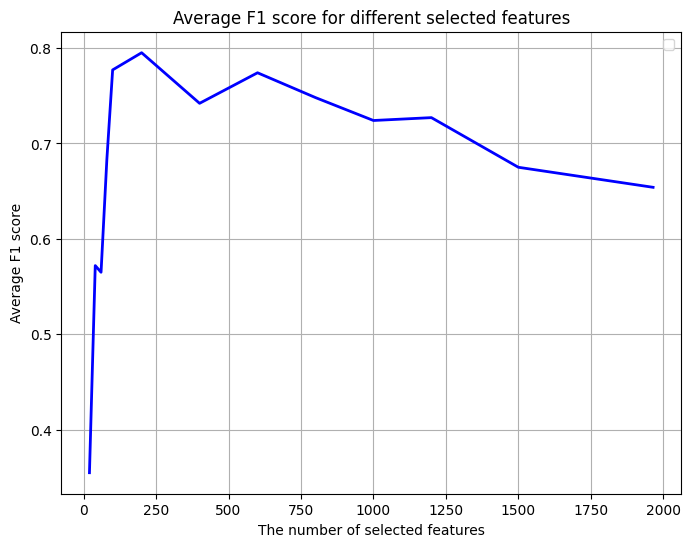

In [ ]:
# We ran multiple simulation and write down the performance for different number of selected features
x = np.array([20,40,60,80,100,200,400,600,800,1000,1200,1500,1965])
y = np.array([0.355, 0.572, 0.565, 0.683, 0.777, 0.795, 0.742, 0.774, 0.748, 0.724, 0.727, 0.675, 0.654])

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Average F1 score for different selected features')
plt.xlabel('The number of selected features')
plt.ylabel('Average F1 score')
plt.legend()

plt.grid(True)

plt.savefig("drive/My Drive/feature.eps", format="eps", dpi=1000)

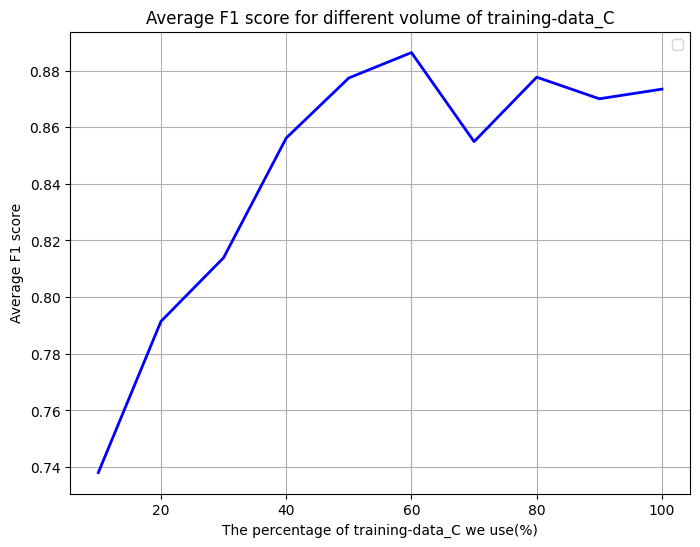

In [ ]:
# We ran multiple simulation and write down the performance for different number data we use from train_data_C
x = np.array([10,20,30,40,50,60,70,80,90,100])
y = np.array([0.737982, 0.791402, 0.813875, 0.856156, 0.877387, 0.886344, 0.854891, 0.877659, 0.870024, 0.873435])

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Average F1 score for different volume of training-data_C')
plt.xlabel('The percentage of training-data_C we use(%)')
plt.ylabel('Average F1 score')
plt.legend()

plt.grid(True)